# Audio Classification

This is a short tutorial to show how to load and classify sound files. First, let's load some libraries and set some variables for computation.

In [1]:
from audio_tools import count_convolutions
from audio_loader import load_audio
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D 
from playsound import save_sound

import IPython
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.
c:\users\lassi\appdata\local\programs\python\python36\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
c:\users\lassi\appdata\local\programs\python\python36\lib\site-packages\pydub\utils.py:179: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)


Then let's set some general settings and load the training data from the folder. 

In [15]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = load_audio("nsynth", num_classes, forceLoad=False, framerate=16384)

batch_size = 30
epochs = 10
kernel_size = 5

Library already loaded!
input/nsynth/mallet_acoustic/mallet_acoustic_047-065-050.wav


Let's look at the graphs and listen to a few examples so we now what we are working with.

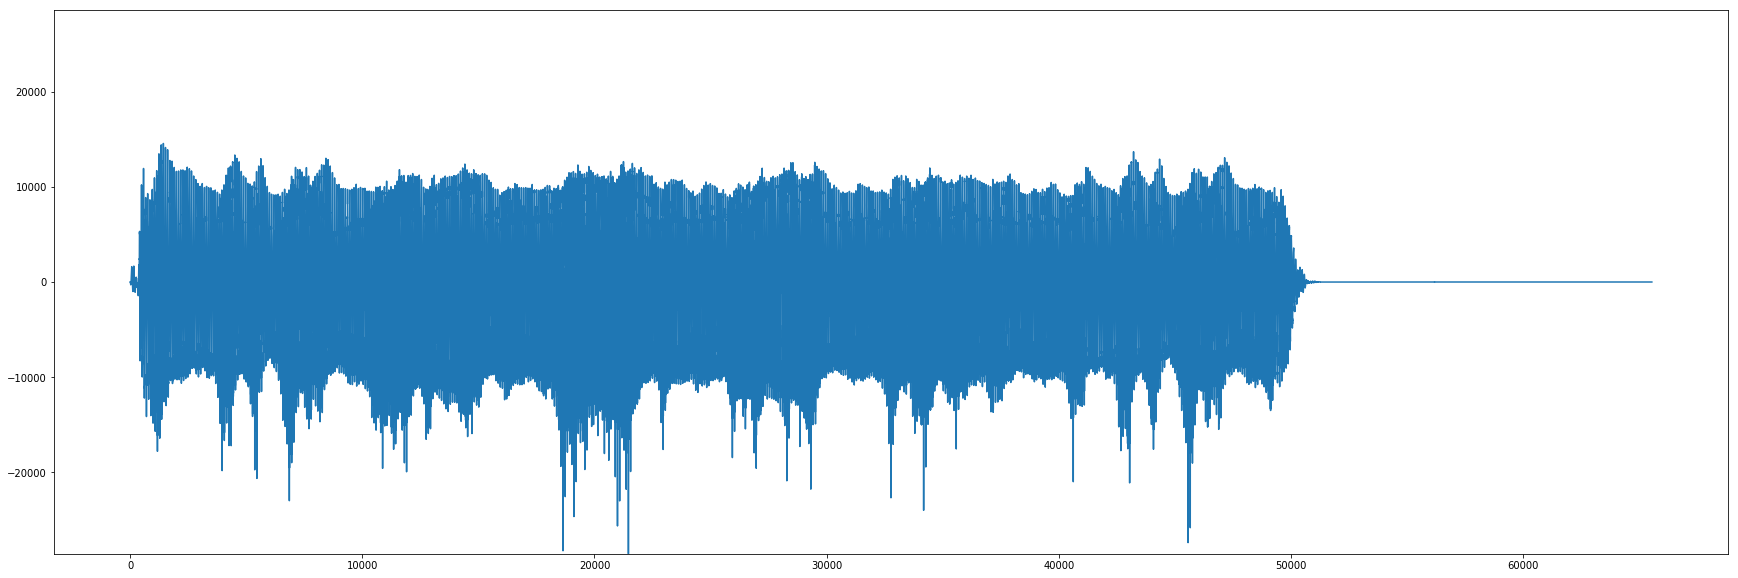

saving sound from category xtrain folder classification


In [4]:
path = save_sound(x_train, "classification","xtrain",upscale=False)
IPython.display.Audio(filename=path)

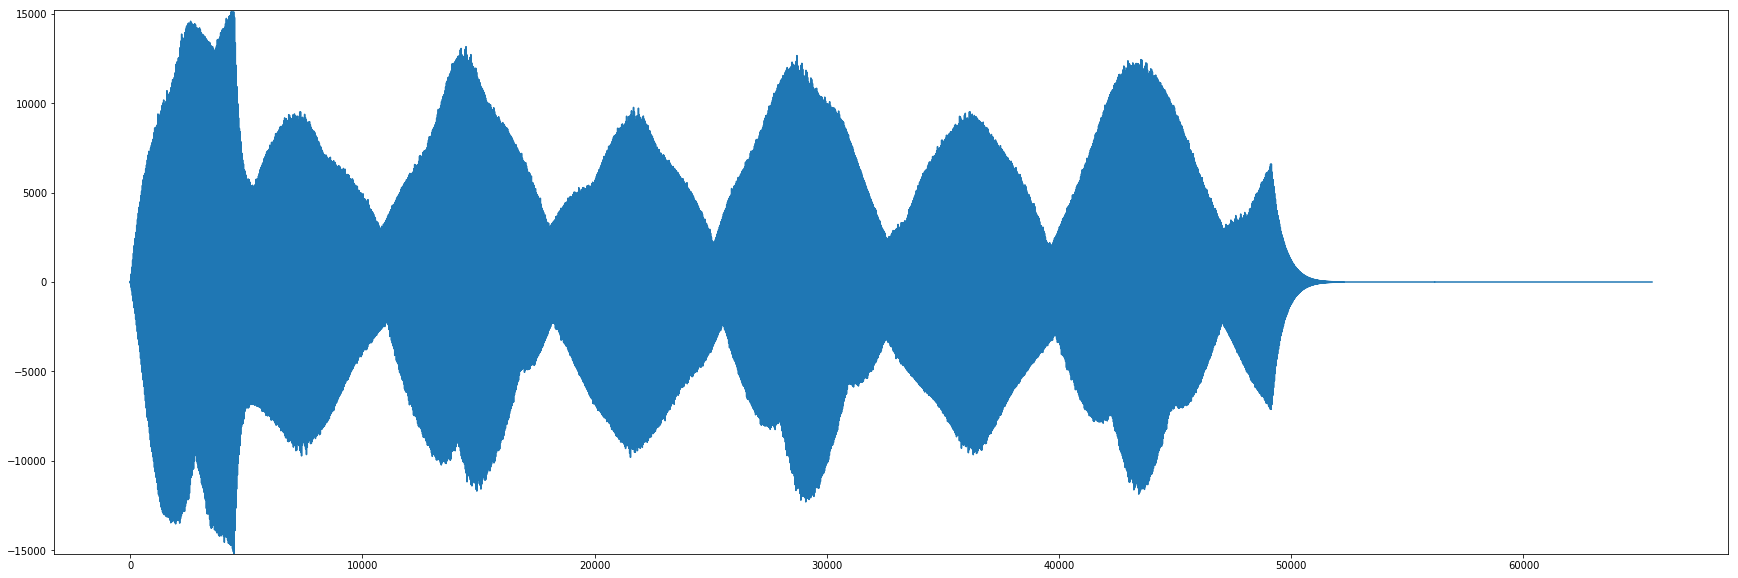

saving sound from category xtest folder classification


In [5]:
path = save_sound(x_test, "classification","xtest",upscale=False)
IPython.display.Audio(filename=path)

Then we neet so set the shape of our data so that we can input into a model.

In [16]:
input_shape = (x_train.shape[1],1)
convolution_layers = count_convolutions(input_shape, kernel_size)

Now for the most important and interesting part! Let's make a model:

In [17]:
model = keras.models.Sequential()

We are using a convolutional model, so we will take five sample cuts of the sounds and condense them down into just 8 values. Stride of two means we cut the amount of values in half on every step.

In [18]:
model.add(Conv1D(16, kernel_size=kernel_size, activation='selu', strides=2, input_shape=input_shape, padding="same"))
for i in range(convolution_layers):
    model.add(Conv1D(32, kernel_size=kernel_size, activation='selu', strides=2,padding="same"))

Then when we have made it as small as we want, accidentally capturing all the relevant features of it, We will flatten our 32 filters of 8 to a long string of 256 numbers.

In [19]:
model.add(Flatten())

To make it so the model doesn't just memorize what it sees, we will randomly drop some connections. The model will have to do without them.

In [20]:
model.add(Dropout(0.5))
model.add(Dense(32, activation='selu'))
model.add(Dropout(0.5))

And for the final point, let's make a layer with 10 outputs, corresponding to the amount of classes we are trying to categorize. Softmax will sort the previous values and figure out which one our classes is the best guess.

In [21]:
model.add(Dense(num_classes, activation='softmax'))

Then we need to compile the model together. Crossentropy tells us to minimize the difference between actual labels and our guesses. Adam is the we roll the ball down the hill and we care about accuracy in our predictions.

In [22]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

And finally, after all that, we can have a look of how the model looks like.

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 32768, 16)         96        
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 16384, 32)         2592      
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 8192, 32)          5152      
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 4096, 32)          5152      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 2048, 32)          5152      
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 1024, 32)          5152      
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 512, 32)           5152      
__________

Now we have 67 914 values to optimize to create a model that can predict what folder our sound file is coming from. Thankfully, we pretty much did all the coding work by just explaining the problem. Now let's put our computational power to use and see how well we do. (This might take a while, even with a good GPU)

In [24]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 6933 samples, validate on 6933 samples
Epoch 1/10
6933/6933 [==============================] - 55s 8ms/step - loss: 3.2972 - acc: 0.2795 - val_loss: 1.3557 - val_acc: 0.5328
Epoch 2/10
6933/6933 [==============================] - 54s 8ms/step - loss: 1.4797 - acc: 0.5213 - val_loss: 0.6629 - val_acc: 0.7681
Epoch 3/10
6933/6933 [==============================] - 54s 8ms/step - loss: 0.9194 - acc: 0.6921 - val_loss: 0.3630 - val_acc: 0.8711
Epoch 4/10
6933/6933 [==============================] - 54s 8ms/step - loss: 0.6212 - acc: 0.7920 - val_loss: 0.1955 - val_acc: 0.9296
Epoch 5/10
6933/6933 [==============================] - 55s 8ms/step - loss: 0.3997 - acc: 0.8683 - val_loss: 0.1275 - val_acc: 0.9564
Epoch 6/10
6933/6933 [==============================] - 55s 8ms/step - loss: 0.3037 - acc: 0.8976 - val_loss: 0.0977 - val_acc: 0.9638
Epoch 7/10
6933/6933 [==============================] - 54s 8ms/step - loss: 0.2935 - acc: 0.9047 - val_loss: 0.0590 - val_acc: 0.9795
Epoch 8

Loss means how much we still have to go to be perfect. It means what cross entropy is reporting as the divergence between our guesses and reality. 

At the end of my run, the accuracy was 0.9867301312649076, how about you?